In [13]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import (
    EulerSolver,
    plot_1d_slice,
)
from superfv.initial_conditions import decaying_turbulence_1d

In [14]:
seed = 3
N = 100
T = 0.02

configs = {
    "p0": dict(riemann_solver="hllc", p=0),
    "MUSCL-Hancock": dict(
        riemann_solver="hllc", p=1, MUSCL=True, MUSCL_limiter="moncen", flux_recipe=2
    ),
    "ZS3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        ZS=True,
        adaptive_dt=True,
        PAD={"rho": (0, None)},
    ),
    "MM3": dict(
        riemann_solver="hllc",
        p=3,
        flux_recipe=2,
        lazy_primitives=True,
        MOOD=True,
        limiting_vars=("rho", "vx"),
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        NAD=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-8,
        PAD={"rho": (0, None)},
    ),
}

In [15]:
sims = {}
for name, config in configs.items():
    print(f"Running simulation: {name}")
    sim = EulerSolver(
        ic=partial(decaying_turbulence_1d, seed=seed, M=10, h=1 / N),
        isothermal=True,
        nx=N,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True)
        sims[name] = sim
    except RuntimeError as e:
        print(f"Simulation '{name}' failed: {e}")

Running simulation: p0
Step #38 @ t=2.04e-02 | dt=5.62e-04 | min(rho)=2.98e-01, min(P)=2.98e-01 | (done)                   
Running simulation: MUSCL-Hancock
Step #38 @ t=2.02e-02 | dt=5.29e-04 | min(rho)=2.78e-01, min(P)=2.78e-01 | (done)                   
Running simulation: ZS3
Step #38 @ t=2.02e-02 | dt=5.43e-04 | min(rho)=2.74e-01, min(P)=2.74e-01 | (done)                   
Running simulation: MM3
Step #38 @ t=2.02e-02 | dt=5.36e-04 | min(rho)=2.81e-01, min(P)=2.81e-01 | (done)                   


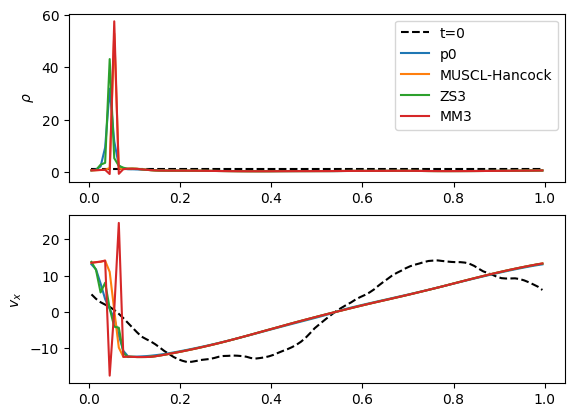

In [16]:
fig, axs = plt.subplots(2, 1)

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$v_x$")

plot_1d_slice(sims["p0"], axs[0], "rho", label="t=0", t=0, color="k", linestyle="--")
plot_1d_slice(sims["p0"], axs[1], "vx", label="t=0", t=0, color="k", linestyle="--")

for name, sim in sims.items():
    plot_1d_slice(sim, axs[0], "rho", label=name)
    plot_1d_slice(sim, axs[1], "vx", label=name)

axs[0].legend()